In [24]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# BASE
# ------------------------------------------------------
import numpy as np
import pandas as pd
import os
import gc
import warnings

# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm

# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

/kaggle/input/store-sales-time-series-forecasting/oil.csv
/kaggle/input/store-sales-time-series-forecasting/sample_submission.csv
/kaggle/input/store-sales-time-series-forecasting/holidays_events.csv
/kaggle/input/store-sales-time-series-forecasting/stores.csv
/kaggle/input/store-sales-time-series-forecasting/train.csv
/kaggle/input/store-sales-time-series-forecasting/test.csv
/kaggle/input/store-sales-time-series-forecasting/transactions.csv


## 1. First Look at the Data

In [25]:
# Import
train = pd.read_csv("./data/store-sales-time-series-forecasting/train.csv")
test = pd.read_csv("./data/store-sales-time-series-forecasting/test.csv")
stores = pd.read_csv("./data/store-sales-time-series-forecasting/stores.csv")
transactions = pd.read_csv("./data/store-sales-time-series-forecasting/transactions.csv").sort_values(["store_nbr", "date"])
oil = pd.read_csv("./data/store-sales-time-series-forecasting/oil.csv")

# Datetime
train["date"] = pd.to_datetime(train.date)
test["date"] = pd.to_datetime(test.date)
transactions["date"] = pd.to_datetime(transactions.date)
oil["date"] = pd.to_datetime(oil.date)

# Data types
train.onpromotion = train.onpromotion.astype("float16")
train.sales = train.sales.astype("float32")

In [26]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00
1,1,2013-01-01,1,BABY CARE,0.00,0.00
2,2,2013-01-01,1,BEAUTY,0.00,0.00
3,3,2013-01-01,1,BEVERAGES,0.00,0.00
4,4,2013-01-01,1,BOOKS,0.00,0.00


In [27]:
print(train.date.min(),train.date.max())
print(train.shape)

2013-01-01 00:00:00 2017-08-15 00:00:00
(3000888, 6)


We have daily data for around 4.5 years. For each day, we have the sales of each category at every location. Looking at the head, we can already see that some locations have no sales for certain categories. We will analyse this later. We probably will be able to remove a lot of data here.

## 2. Visualisation of the Data

In [28]:
# Define a function that groups data by frequency
def grouped(df, key, freq, col):
    """ GROUP DATA WITH CERTAIN FREQUENCY """
    df_grouped = df.groupby([pd.Grouper(key=key, freq=freq)]).agg(mean = (col, 'mean'))
    df_grouped = df_grouped.reset_index()
    return df_grouped

In [29]:
sales_daily = grouped(train, 'date', 'D','sales')
sales_weekly = grouped(train, 'date', 'W','sales')
sales_monthly = grouped(train, 'date', 'M','sales')

sales_weekly['id']= np.arange(1, len(sales_weekly) + 1)
sales_monthly['id']= np.arange(1, len(sales_monthly) + 1)

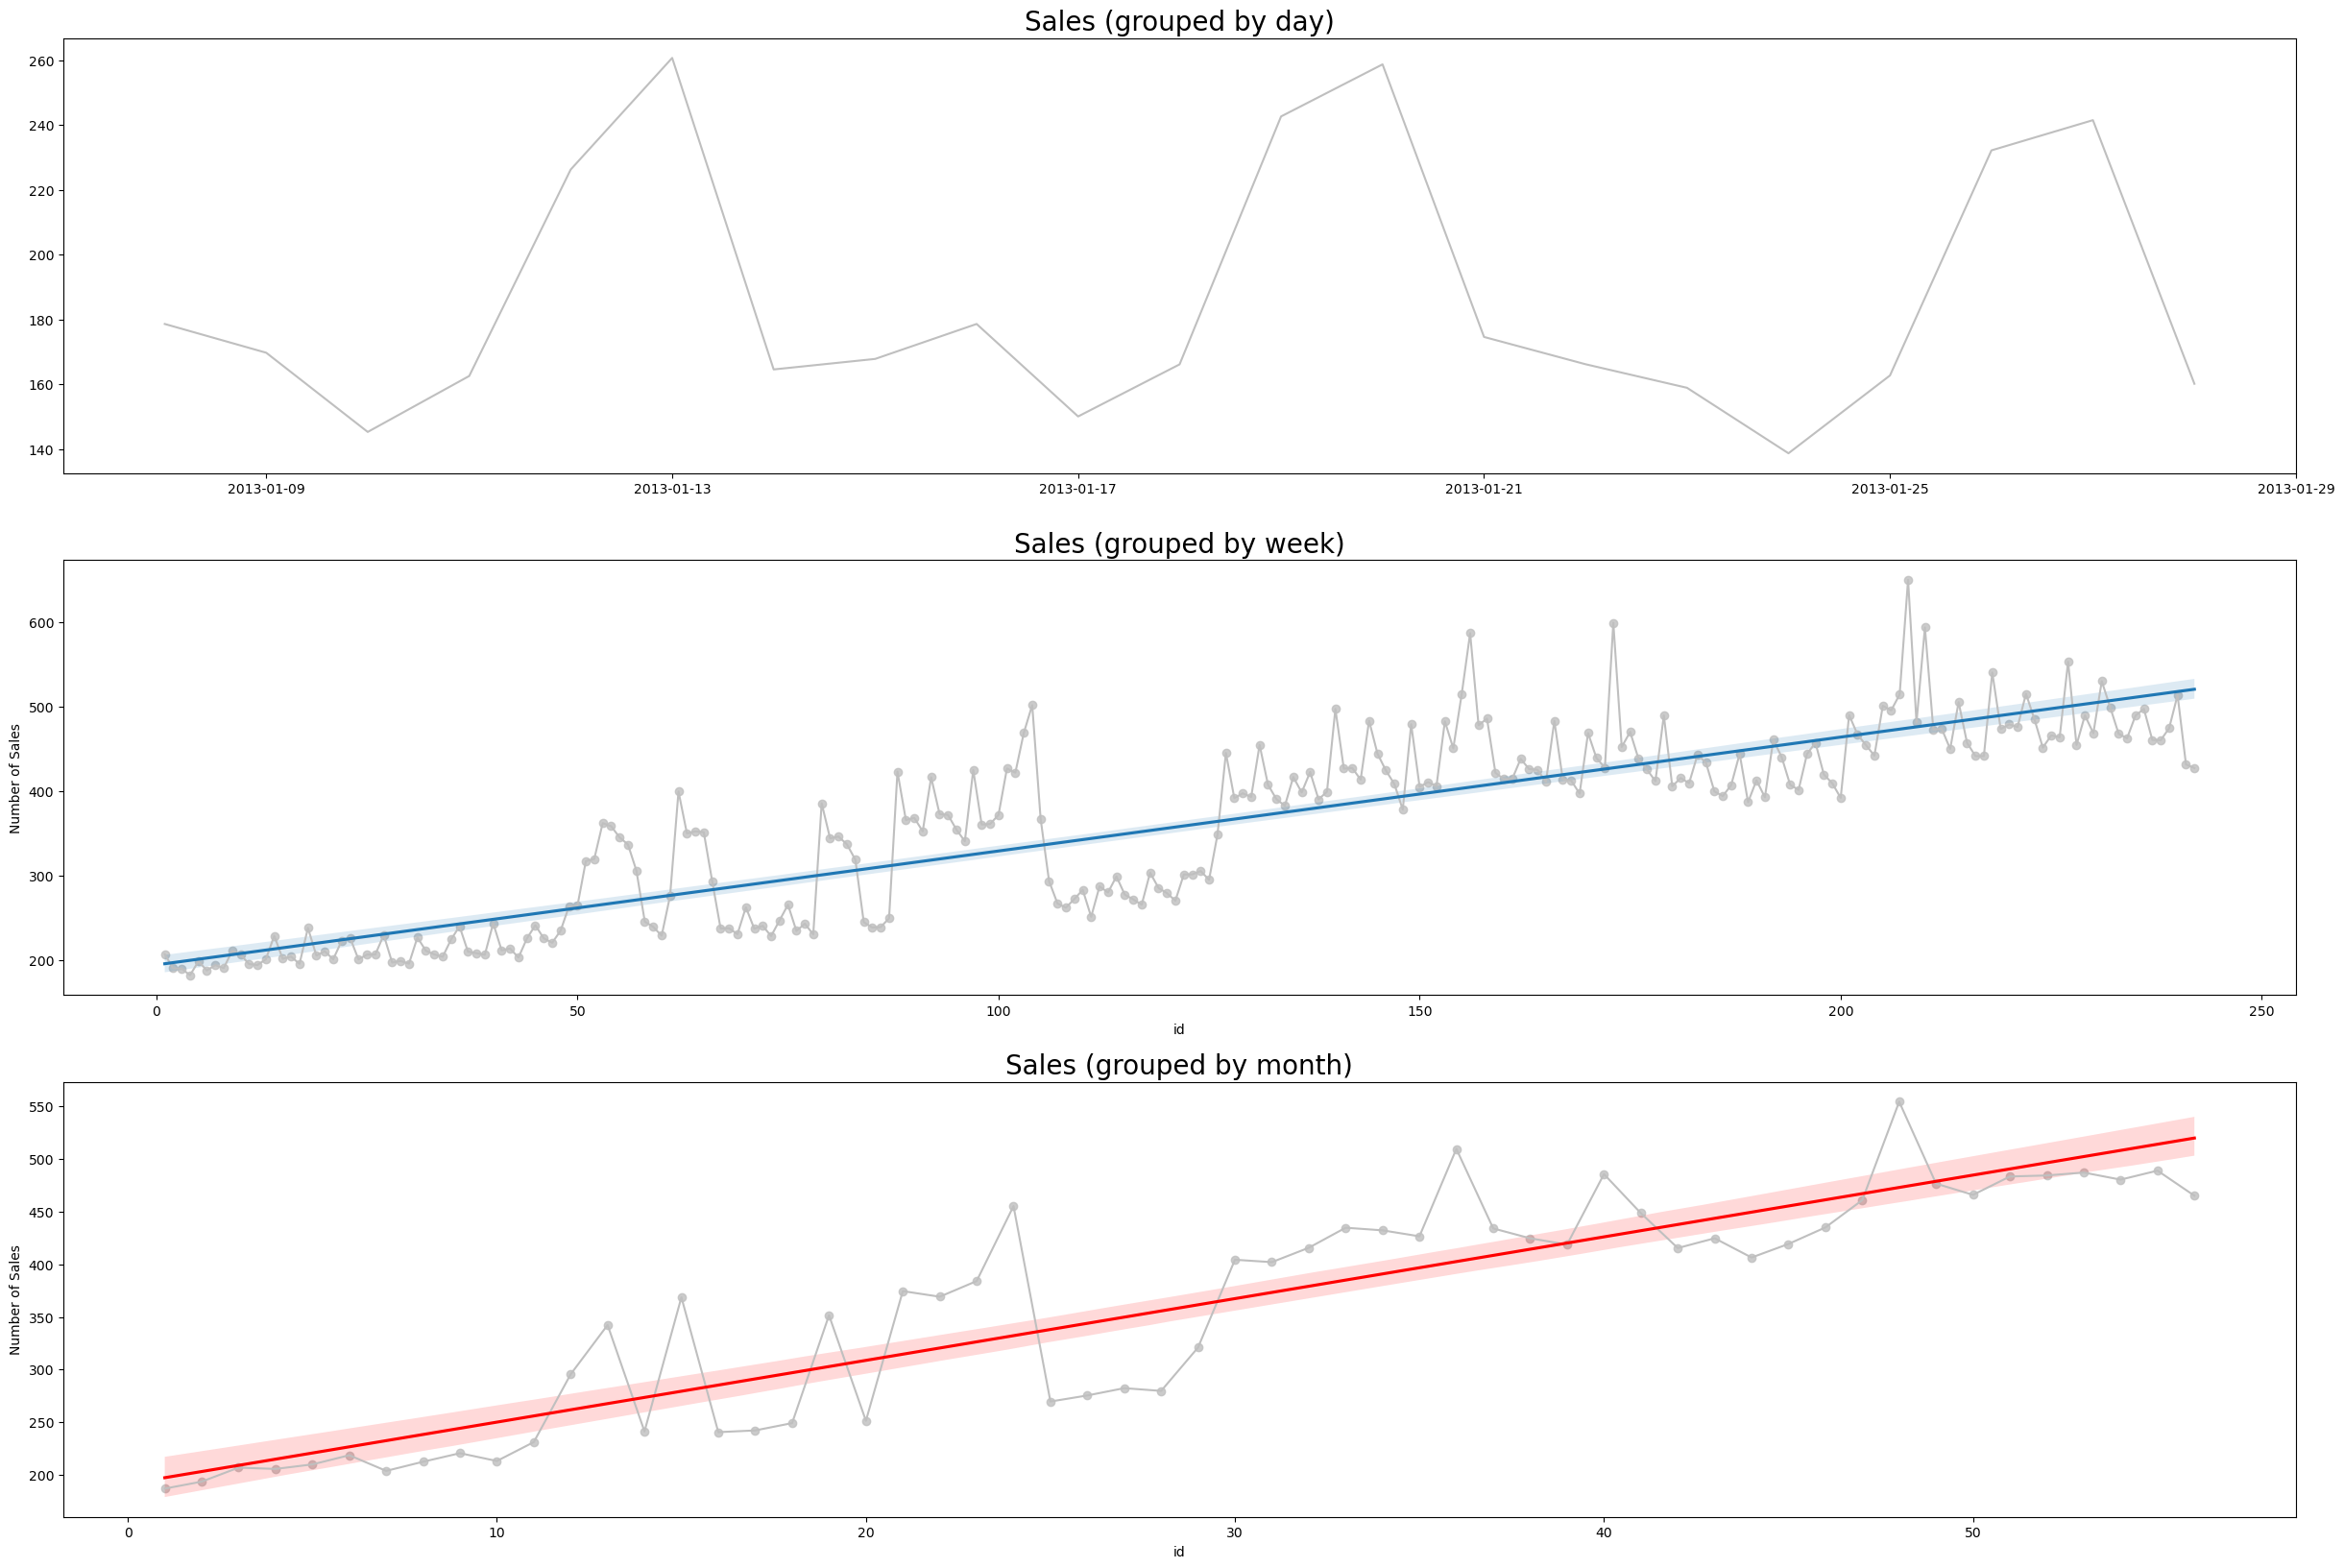

In [30]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(30,20))
# Transactions (Daily)
axes[0].plot('date', 'mean', data=sales_daily[7:28], color='0.75')
axes[0].set_title("Sales (grouped by day)", fontsize=20)


# Transactions (WEEKLY)
axes[1].plot('id', 'mean', data=sales_weekly, color='0.75')
axes[1].set_title("Sales (grouped by week)", fontsize=20)
# linear regression
axes[1] = sns.regplot(x='id', 
                      y='mean', 
                      data=sales_weekly, 
                      scatter_kws=dict(color='0.75'), 
                      ax = axes[1])
axes[1].set(ylabel='Number of Sales')

# Transactions (MONTHLY)
axes[2].plot('id', 'mean', data=sales_monthly, color='0.75')
axes[2].set_title("Sales (grouped by month)", fontsize=20)
# linear regression
axes[2] = sns.regplot(x='id', 
                      y='mean', 
                      data=sales_monthly, 
                      scatter_kws=dict(color='0.75'), 
                      line_kws={"color": "red"},
                      ax = axes[2])
axes[2].set(ylabel='Number of Sales')


plt.show()

We identifiy two seasonalities:
* Increase in sales in December
* Increase in sales on weekends

In [31]:
import plotly.express as px

In [32]:
a = transactions.set_index("date").resample("M").transactions.mean().reset_index()
a["year"] = a.date.dt.year
px.line(a, x='date', y='transactions', color='year',title = "Monthly Average Transactions" )

Below, we verify that the sales are increased during weekends.

In [33]:
a = train.copy()
a["year"] = a.date.dt.year
a["dayofweek"] = a.date.dt.dayofweek+1
a = a.groupby(["year", "dayofweek"]).sales.mean().reset_index()
px.line(a, x="dayofweek", y="sales" , color = "year", title = "Sales")

## Oil Price

After analysing the sales and its seasonality, we turn our focus on the oil price

In [34]:
oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


We see that there are missing values in the dataset. We fill them by taking the average between the previous and following value.

In [35]:
oil["date"] = pd.to_datetime(oil.date)
oil.date

0      2013-01-01
1      2013-01-02
2      2013-01-03
3      2013-01-04
4      2013-01-07
          ...    
1213   2017-08-25
1214   2017-08-28
1215   2017-08-29
1216   2017-08-30
1217   2017-08-31
Name: date, Length: 1218, dtype: datetime64[ns]

In [36]:
# Resample
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()
oil["dcoilwtico"] = np.where(oil["dcoilwtico"] == 0, np.nan, oil["dcoilwtico"])
oil["dcoilwtico_interpolated"] =oil.dcoilwtico.interpolate()
oil.dcoilwtico_interpolated = oil.dcoilwtico_interpolated.bfill()

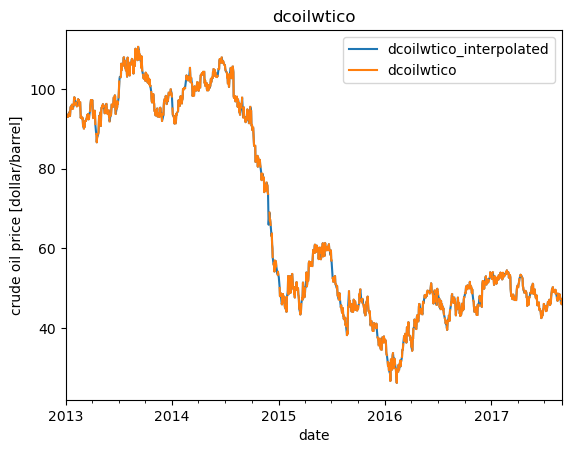

In [37]:
# Let's start with oil because it is the easiest dataframe
oil.plot(x="date", y=["dcoilwtico_interpolated", "dcoilwtico"], title ="dcoilwtico")
plt.ylabel('crude oil price [dollar/barrel]')
plt.show()

In [38]:
oil.head(10)

,date,dcoilwtico,dcoilwtico_interpolated
0,2013-01-01,NaN,93.14
1,2013-01-02,93.14,93.14
2,2013-01-03,92.97,92.97
3,2013-01-04,93.12,93.12
4,2013-01-05,NaN,93.15
5,2013-01-06,NaN,93.17
6,2013-01-07,93.20,93.20
7,2013-01-08,93.21,93.21
8,2013-01-09,93.08,93.08
9,2013-01-10,93.81,93.81


**Is there a correlation between the oil price and Sales?**

Ecuador is said to be an oil-dependent country, let's see if that statement is reflected by the data. We expect that if the oil price is high the sales are lowered. However, looking at the previous plots, we see that the oil price drops drastically in 2014. Therefore, following this hypothesis, the sales should be higher in 2015 compared to 2014, which they are not.

Correlation with Daily Oil Prices
sales          -0.30
transactions    0.04
Name: dcoilwtico_interpolated, dtype: float64 



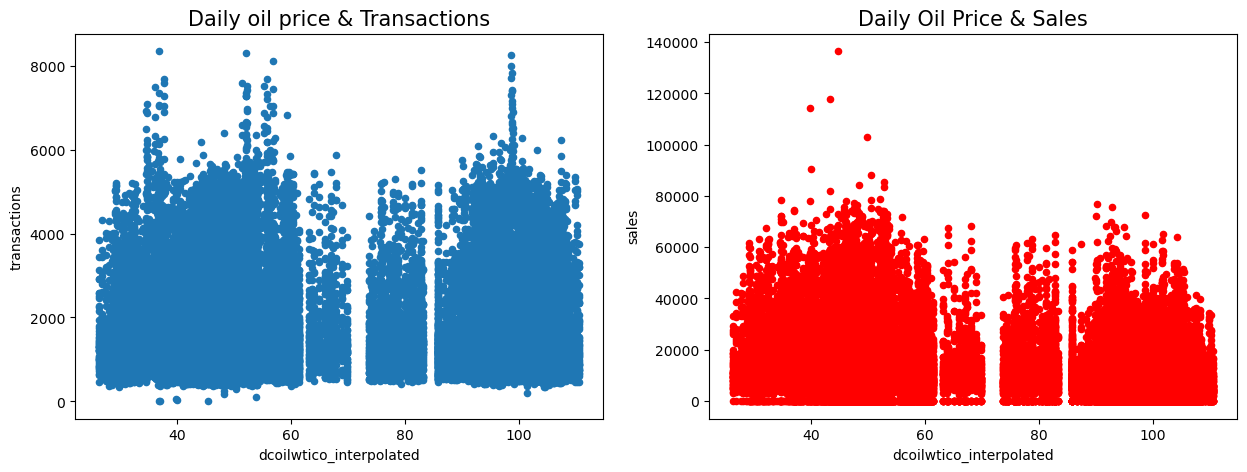

In [39]:
temp = pd.merge(train.groupby(["date", "store_nbr"]).sales.sum().reset_index(), transactions, how = "left")
temp = pd.merge(temp, oil, how = "left")
print("Correlation with Daily Oil Prices")
print(temp.drop(["store_nbr", "dcoilwtico"], axis = 1).corr("spearman").dcoilwtico_interpolated.loc[["sales", "transactions"]], "\n")

fig, axes = plt.subplots(1, 2, figsize = (15,5))
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "transactions", ax=axes[0])
temp.plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes[1], color = "r")
axes[0].set_title('Daily oil price & Transactions', fontsize = 15)
axes[1].set_title('Daily Oil Price & Sales', fontsize = 15);

The correlation coefficient shows a mild negative correlation between oil price and sales, which is not really visible in the plots.

In [40]:
a.head()

,year,dayofweek,sales
0,2013,1,211.24
1,2013,2,186.24
2,2013,3,192.27
3,2013,4,173.58
4,2013,5,195.14


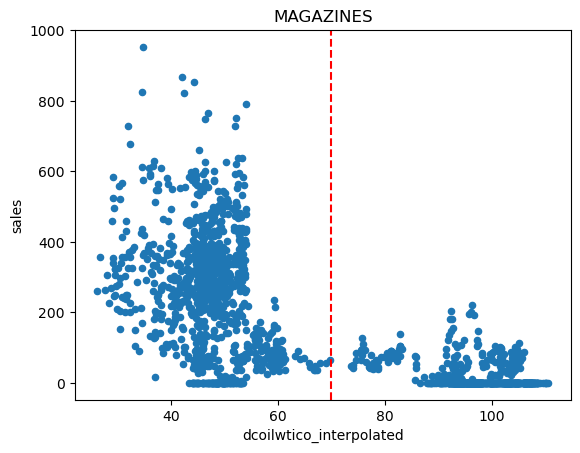

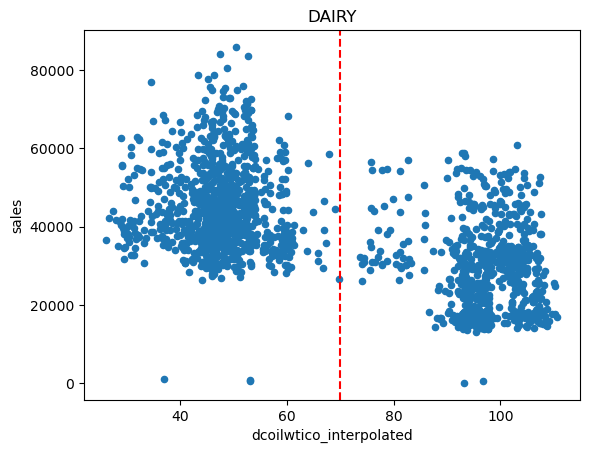

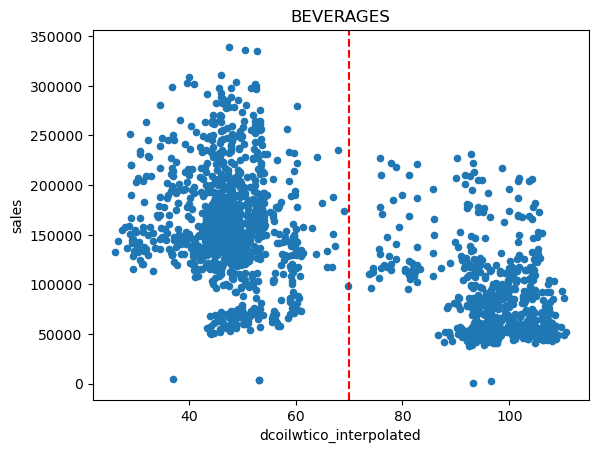

In [41]:
a = pd.merge(train.groupby(["date", "family"]).sales.sum().reset_index(), oil.drop("dcoilwtico", axis = 1), how = "left")
c = a.groupby("family").corr("spearman").reset_index()
c = c[c.level_1 == "dcoilwtico_interpolated"][["family", "sales"]].sort_values("sales")

for fam in ['MAGAZINES','DAIRY','BEVERAGES']:
    fig, axes = plt.subplots()
    a[a.family == fam].plot.scatter(x = "dcoilwtico_interpolated", y = "sales", ax=axes)
    axes.set_title(fam)
    axes.axvline(x=70, color='r', linestyle='--')
    plt.show()

In these plots, we can actually see that the oil price is influencing the number of sales. I showed some examples of the different categories. 

## Zeros

We do one more step of data analysis before we continue. There are stors that don't sell any a certain kind of family. Therefore, the forecast for these will be 0.

In [42]:
c = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
c = c[c.sales == 0]
c

,store_nbr,family,sales
1,1,BABY CARE,0.00
397,13,BABY CARE,0.00
727,23,BABY CARE,0.00
1420,44,BABY CARE,0.00
1453,45,BABY CARE,0.00
1486,46,BABY CARE,0.00
1519,47,BABY CARE,0.00
1552,48,BABY CARE,0.00
1585,49,BABY CARE,0.00
1618,50,BABY CARE,0.00


Remove zeros the categories that are not present in store locations from the train dataframe

In [43]:
print(train.shape)
# Anti Join
outer_join = train.merge(c[c.sales == 0].drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
gc.collect()
train.shape

(3000888, 6)


(2911636, 6)

Create prediction for these stores. We later on join them to our forecast.

In [44]:
zero_prediction = []
for i in range(0,len(c)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":c.store_nbr.iloc[i],
            "family":c.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del c
gc.collect()
zero_prediction

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0
...,...,...,...,...
11,2017-08-27,54,LAWN AND GARDEN,0
12,2017-08-28,54,LAWN AND GARDEN,0
13,2017-08-29,54,LAWN AND GARDEN,0
14,2017-08-30,54,LAWN AND GARDEN,0


## Holidays and Events

For holidays there is a lot of small things to do. First we combine additional bank holidays and bridge holidays together into one category. Then, we will take care of the scope of the holiday national or local. Finally, we will have hot-one encoding for every holiday.

In [45]:
holidays = pd.read_csv("../input/store-sales-time-series-forecasting/holidays_events.csv")
holidays["date"] = pd.to_datetime(holidays.date)


# Transferred Holidays
tr1 = holidays[(holidays.type == "Holiday") & (holidays.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays[(holidays.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
tr = pd.concat([tr1,tr2], axis = 1)
tr = tr.iloc[:, [5,1,2,3,4]]

holidays = holidays[(holidays.transferred == False) & (holidays.type != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(tr).reset_index(drop = True)


# Additional Holidays
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

# Bridge Holidays
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

 
# Work Day Holidays, that is meant to payback the Bridge.
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  


# Split

# Events are national
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)

holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
regional = holidays[holidays.locale == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()



d = pd.merge(train.append(test), stores)
d["store_nbr"] = d["store_nbr"].astype("int8")


# National Holidays & Events
#d = pd.merge(d, events, how = "left")
d = pd.merge(d, national, how = "left")
# Regional
d = pd.merge(d, regional, how = "left", on = ["date", "state"])
# Local
d = pd.merge(d, local, how = "left", on = ["date", "city"])

# Work Day: It will be removed when real work day colum created
d = pd.merge(d,  work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

# EVENTS
events["events"] =np.where(events.events.str.contains("futbol"), "Futbol", events.events)

def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

events, events_cat = one_hot_encoder(events, nan_as_category=False)
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

d = pd.merge(d, events, how = "left")
d[events_cat] = d[events_cat].fillna(0)

# New features
d["holiday_national_binary"] = np.where(d.holiday_national.notnull(), 1, 0)
d["holiday_local_binary"] = np.where(d.holiday_local.notnull(), 1, 0)
d["holiday_regional_binary"] = np.where(d.holiday_regional.notnull(), 1, 0)

# 
d["national_independence"] = np.where(d.holiday_national.isin(['Batalla de Pichincha',  'Independencia de Cuenca', 'Independencia de Guayaquil', 'Independencia de Guayaquil', 'Primer Grito de Independencia']), 1, 0)
d["local_cantonizacio"] = np.where(d.holiday_local.str.contains("Cantonizacio"), 1, 0)
d["local_fundacion"] = np.where(d.holiday_local.str.contains("Fundacion"), 1, 0)
d["local_independencia"] = np.where(d.holiday_local.str.contains("Independencia"), 1, 0)


holidays, holidays_cat = one_hot_encoder(d[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)
d = pd.concat([d.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1),holidays], axis = 1)

he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
d[he_cols] = d[he_cols].astype("int8")

d[["family", "city", "state", "type"]] = d[["family", "city", "state", "type"]].astype("category")

del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, tr, tr1, tr2, he_cols
gc.collect()

d.head(10)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,IsWorkDay,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.00,0.00,Quito,Pichincha,D,13,Work Day,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,8910,2013-01-06,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,10692,2013-01-07,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,12474,2013-01-08,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,14256,2013-01-09,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9,16038,2013-01-10,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,NaN,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Now we can do AB testing for the events and holidays and look for statistically significance.
* A: The sales are equal (M1=M2)
* B: The sales are not equal (M1!=M2)

In [46]:
def AB_Test(dataframe, group, target):
    
    # Packages
    from scipy.stats import shapiro
    import scipy.stats as stats
    
    # Split A/B
    groupA = dataframe[dataframe[group] == 1][target]
    groupB = dataframe[dataframe[group] == 0][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    temp["Feature"] = group
    temp["GroupA_mean"] = groupA.mean()
    temp["GroupB_mean"] = groupB.mean()
    temp["GroupA_median"] = groupA.median()
    temp["GroupB_median"] = groupB.median()
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Feature","Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    else:
        temp = temp[["Feature","Test Type","AB Hypothesis", "p-value", "Comment", "GroupA_mean", "GroupB_mean", "GroupA_median", "GroupB_median"]]
    
    # Print Hypothesis
    # print("# A/B Testing Hypothesis")
    # print("H0: A == B")
    # print("H1: A != B", "\n")
    
    return temp
    
# Apply A/B Testing
he_cols = d.columns[d.columns.str.startswith("events")].tolist() + d.columns[d.columns.str.startswith("holiday")].tolist() + d.columns[d.columns.str.startswith("national")].tolist()+ d.columns[d.columns.str.startswith("local")].tolist()
ab = []
for i in he_cols:
    ab.append(AB_Test(dataframe=d[d.sales.notnull()], group = i, target = "sales"))
ab = pd.concat(ab)
ab

,Feature,Test Type,AB Hypothesis,p-value,Comment,GroupA_mean,GroupB_mean,GroupA_median,GroupB_median
0,events_Black_Friday,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,374.50,368.73,20.00,13.00
0,events_Cyber_Monday,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,449.59,368.60,20.00,13.00
0,events_Dia_de_la_Madre,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,359.22,368.77,11.00,13.00
0,events_Futbol,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,320.50,369.15,6.00,13.00
0,events_Terremoto_Manabi,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,510.07,366.09,27.00,12.00
0,holiday_national_binary,Non-Parametric,Reject H0,0.01,A/B groups are not similar!,437.46,365.41,13.00,13.00
0,holiday_local_binary,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,440.23,368.46,17.00,13.00
0,holiday_regional_binary,Non-Parametric,Reject H0,0.00,A/B groups are not similar!,238.10,368.79,8.00,13.00
0,holiday_national_Batalla_de_Pichincha,Non-Parametric,Fail to Reject H0,0.57,A/B groups are similar!,403.73,368.64,14.00,13.00
0,holiday_national_Carnaval,Non-Parametric,Reject H0,0.01,A/B groups are not similar!,343.09,368.90,12.00,13.00


We can see that on approximately half of the holidays, the sales are affected and our hypethesis A that the sales are equal is rejected.

In [47]:
# Time Related Features
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
    df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
    df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df["quarter"] = df.date.dt.quarter.astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
    df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    return df
d = create_date_features(d)




# Workday column
d["workday"] = np.where((d.holiday_national_binary == 1) | (d.holiday_local_binary==1) | (d.holiday_regional_binary==1) | (d['day_of_week'].isin([6,7])), 0, 1)
d["workday"] = pd.Series(np.where(d.IsWorkDay.notnull(), 1, d["workday"])).astype("int8")
d.drop("IsWorkDay", axis = 1, inplace = True)

# Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. 
# Supermarket sales could be affected by this.
d["wageday"] = pd.Series(np.where((d['is_month_end'] == 1) | (d["day_of_month"] == 15), 1, 0)).astype("int8")

d.head(15)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Futbol,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary,national_independence,local_cantonizacio,local_fundacion,local_independencia,holiday_national_Batalla_de_Pichincha,holiday_national_Carnaval,holiday_national_Dia_de_Difuntos,holiday_national_Dia_de_la_Madre,holiday_national_Dia_del_Trabajo,holiday_national_Independencia_de_Cuenca,holiday_national_Independencia_de_Guayaquil,holiday_national_Navidad,holiday_national_Primer_Grito_de_Independencia,holiday_national_Primer_dia_del_ano,holiday_national_Viernes_Santo,holiday_regional_Provincializacion_Santa_Elena,holiday_regional_Provincializacion_de_Cotopaxi,holiday_regional_Provincializacion_de_Imbabura,holiday_regional_Provincializacion_de_Santo_Domingo,holiday_local_Cantonizacion_de_Cayambe,holiday_local_Cantonizacion_de_El_Carmen,holiday_local_Cantonizacion_de_Guaranda,holiday_local_Cantonizacion_de_Latacunga,holiday_local_Cantonizacion_de_Libertad,holiday_local_Cantonizacion_de_Quevedo,holiday_local_Cantonizacion_de_Riobamba,holiday_local_Cantonizacion_de_Salinas,holiday_local_Cantonizacion_del_Puyo,holiday_local_Fundacion_de_Ambato,holiday_local_Fundacion_de_Cuenca,holiday_local_Fundacion_de_Esmeraldas,holiday_local_Fundacion_de_Guayaquil,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga,month,day_of_month,day_of_year,week_of_month,week_of_year,day_of_week,year,is_wknd,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,season,workday,wageday
0,0,2013-01-01,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,2,2013,0,1,1,0,1,0,1,0,0,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,2,2,1,1,3,2013,0,1,0,0,0,0,0,0,0,1,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,3,1,1,4,2013,0,1,0,0,0,0,0,0,0,1,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,4,4,1,1,5,2013,1,1,0,0,0,0,0,0,0,1,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,5,5,1,1,6,2013,1,1,0,0,0,0,0,0,0,1,0
5,8910,2013-01-06,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,6,1,1,7,2013,1,1,0,0,0,0,0,0,0,0,0
6,10692,2013-01-07,1,AUTOMOTIVE,0.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,7,1,2,1,2013,0,1,0,0,0,0,0,0,0,1,0
7,12474,2013-01-08,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,8,8,2,2,2,2013,0,1,0,0,0,0,0,0,0,1,0
8,14256,2013-01-09,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,9,9,2,2,3,2013,0,1,0,0,0,0,0,0,0,1,0
9,16038,2013-01-10,1,AUTOMOTIVE,2.00,0.00,Quito,Pichincha,D,13,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,10,10,2,2,4,2013,0,1,0,0,0,0,0,0,0,1,0


In [48]:
a = train.sort_values(["store_nbr", "family", "date"])
for i in [20, 30, 45, 60, 90, 120, 365, 730]:
    a["SMA"+str(i)+"_sales_lag16"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(16).values
    a["SMA"+str(i)+"_sales_lag30"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(30).values
    a["SMA"+str(i)+"_sales_lag60"] = a.groupby(["store_nbr", "family"]).rolling(i).sales.mean().shift(60).values
print("Correlation")
a[["sales"]+a.columns[a.columns.str.startswith("SMA")].tolist()].corr()

Correlation


,sales,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,SMA30_sales_lag16,SMA30_sales_lag30,SMA30_sales_lag60,SMA45_sales_lag16,SMA45_sales_lag30,SMA45_sales_lag60,SMA60_sales_lag16,SMA60_sales_lag30,SMA60_sales_lag60,SMA90_sales_lag16,SMA90_sales_lag30,SMA90_sales_lag60,SMA120_sales_lag16,SMA120_sales_lag30,SMA120_sales_lag60,SMA365_sales_lag16,SMA365_sales_lag30,SMA365_sales_lag60,SMA730_sales_lag16,SMA730_sales_lag30,SMA730_sales_lag60
sales,1.00,0.91,0.89,0.87,0.91,0.89,0.87,0.91,0.90,0.87,0.91,0.89,0.87,0.91,0.89,0.87,0.90,0.89,0.86,0.90,0.89,0.86,0.90,0.88,0.85
SMA20_sales_lag16,0.91,1.00,0.99,0.95,1.00,0.98,0.95,0.99,0.98,0.95,0.99,0.98,0.95,0.99,0.98,0.95,0.98,0.97,0.94,0.97,0.97,0.95,0.97,0.97,0.94
SMA20_sales_lag30,0.89,0.99,1.00,0.96,0.99,1.00,0.96,1.00,0.99,0.97,0.99,0.99,0.97,0.99,0.99,0.96,0.99,0.98,0.96,0.97,0.97,0.96,0.97,0.97,0.96
SMA20_sales_lag60,0.87,0.95,0.96,1.00,0.96,0.98,1.00,0.98,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.97,0.97,0.97,0.97,0.97,0.97
SMA30_sales_lag16,0.91,1.00,0.99,0.96,1.00,0.99,0.96,1.00,0.99,0.96,0.99,0.99,0.96,0.99,0.98,0.96,0.99,0.98,0.96,0.97,0.97,0.96,0.97,0.97,0.95
SMA30_sales_lag30,0.89,0.98,1.00,0.98,0.99,1.00,0.98,1.00,1.00,0.98,1.00,0.99,0.98,0.99,0.99,0.97,0.99,0.99,0.97,0.98,0.97,0.97,0.97,0.97,0.97
SMA30_sales_lag60,0.87,0.95,0.96,1.00,0.96,0.98,1.00,0.98,0.99,1.00,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.98,0.98,0.97,0.97,0.97,0.97
SMA45_sales_lag16,0.91,0.99,1.00,0.98,1.00,1.00,0.98,1.00,1.00,0.98,1.00,0.99,0.98,0.99,0.99,0.97,0.99,0.99,0.97,0.98,0.98,0.97,0.98,0.97,0.97
SMA45_sales_lag30,0.90,0.98,0.99,0.99,0.99,1.00,0.99,1.00,1.00,0.99,1.00,1.00,0.99,1.00,0.99,0.98,0.99,0.99,0.98,0.98,0.98,0.97,0.98,0.98,0.97
SMA45_sales_lag60,0.87,0.95,0.97,0.99,0.96,0.98,1.00,0.98,0.99,1.00,0.99,0.99,1.00,0.99,1.00,0.99,0.99,0.99,0.99,0.98,0.98,0.98,0.98,0.98,0.98


In [49]:
def ewm_features(dataframe, alphas, lags):
    dataframe = dataframe.copy()
    for alpha in alphas:
        for lag in lags:
            dataframe['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                dataframe.groupby(["store_nbr", "family"])['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [0,7, 30, 60, 90]

a = ewm_features(a, alphas, lags)

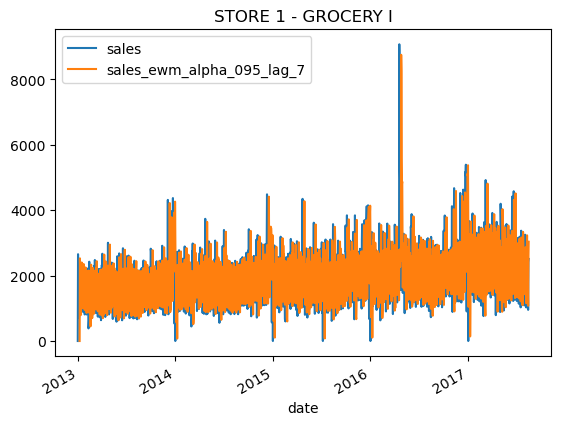

In [50]:
a[(a.store_nbr == 1) & (a.family == "GROCERY I")].set_index("date")[["sales", "sales_ewm_alpha_095_lag_7"]].plot(title = "STORE 1 - GROCERY I");

The exponential moving average is able to match the data quite well. We continue along this line of modelling and use Seasonal Autoregressive Integrated Moving Average (SARIMA) describe the data and make forecasts.

## Creat Lag features

In [437]:
# We focus on one family and average over all stores
b=a.loc[a['family'] ==  'AUTOMOTIVE']
b=b[['date','sales','onpromotion']]
#display(b.head())
# Average over all stores
b = b.groupby(b.date.dt.date).sum().reset_index()
b.date = pd.to_datetime(b.date)

In [438]:
def create_lags(df):

    new_df = df.copy()
    keys = ['store_nbr', 'family']
    val = 'sales'
    lags = [16, 21, 30, 45, 60, 90, 120, 365, 730]
    
    for lag in lags:
        new_df['lag_' + str(lag)] = new_df[val].transform(lambda x: x.shift(lag))
    
    return new_df

b = create_lags(b)


In [439]:
def create_rolling_mean(df):
    
    new_df = df.sort_values(["date", "sales"]).copy()
    shifts = [20, 30, 45, 60, 90, 120, 365, 730]
    
    for i in [20]:
        new_df["SMA"+str(i)+"_sales_lag16"] = new_df.rolling(i).sales.mean().shift(16).values
        new_df["SMA"+str(i)+"_sales_lag30"] = new_df.rolling(i).sales.mean().shift(30).values
        new_df["SMA"+str(i)+"_sales_lag60"] = new_df.rolling(i).sales.mean().shift(60).values
    
    return new_df

b = create_rolling_mean(b)


In [440]:
def create_exp_mov_av(df):

    new_df = df.copy()
    alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
    lags = [16, 30, 60, 90]

    for alpha in alphas:
        for lag in lags:
            new_df['sales_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = \
                new_df['sales']. \
                    transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
            
    return new_df

b = create_exp_mov_av(b)
b.tail()

,date,sales,onpromotion,lag_16,lag_21,lag_30,lag_45,lag_60,lag_90,lag_120,lag_365,lag_730,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,sales_ewm_alpha_095_lag_16,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_16,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_16,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_16,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_16,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90
1679,2017-08-11,441.00,0.00,296.00,353.00,286.00,306.00,317.00,439.00,403.00,309.00,432.00,374.20,396.45,408.50,297.24,286.87,328.25,431.90,298.72,288.00,339.21,424.88,302.82,291.57,359.85,411.12,308.92,297.63,377.97,397.82,327.73,318.35,403.53,374.47
1680,2017-08-12,403.00,1.00,339.00,493.00,331.00,315.00,340.00,352.00,493.00,303.00,344.00,375.75,396.05,409.85,336.91,328.79,339.41,355.99,334.97,326.70,339.92,359.29,331.76,323.11,343.97,363.82,329.98,320.99,351.39,365.75,333.36,324.67,371.76,363.23
1681,2017-08-13,481.00,0.00,344.00,489.00,325.00,324.00,351.00,337.00,540.00,377.00,265.00,367.10,387.65,414.05,343.65,325.19,350.42,337.95,343.10,325.17,349.89,339.23,341.55,324.62,349.59,342.36,339.79,323.80,351.12,345.62,338.68,324.84,361.38,350.12
1682,2017-08-14,292.00,0.00,541.00,347.00,460.00,342.00,342.00,338.00,499.00,382.00,245.00,367.45,381.60,404.05,531.13,453.26,342.42,338.00,521.21,446.52,342.79,338.12,501.11,432.92,343.52,338.87,480.64,419.14,344.74,340.29,439.84,392.42,351.69,344.06
1683,2017-08-15,337.00,1.00,529.00,319.00,533.00,618.00,344.00,347.00,347.00,348.00,292.00,377.85,390.15,396.30,529.11,529.01,343.92,346.55,528.22,524.35,343.88,346.11,523.42,512.98,343.90,345.37,514.49,498.84,344.22,344.99,484.42,462.71,347.85,345.53


## SARIMA

In [441]:
!pip install pmdarima

^C
ERROR: Operation cancelled by user


In [442]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm
warnings.filterwarnings('ignore')

Let's prepare the dataset for analysis

In [444]:
# We focus on one family and average over all stores
sarima_df=b
sarima_df.date = pd.to_datetime(sarima_df.date)
# Add workday feature
sarima_df = sarima_df.merge(d[['date','workday', 'wageday', 'day_of_year', 'month', 'year']],  on=['date'], how='left').drop_duplicates()
sarima_df = sarima_df.merge(oil[['date','dcoilwtico_interpolated']],  on=['date'], how='left').drop_duplicates()
# Add feature for december
sarima_df["is_december"] = np.where(sarima_df.date.dt.month==12, 1, 0)
# Reset the counting index
sarima_df.onpromotion=sarima_df.onpromotion.astype('float32')
# Reduce to current year
sarima_df=sarima_df[:]

sarima_df = sarima_df.reset_index().drop('index',axis=1)
sarima_df.tail(10)

,date,sales,onpromotion,lag_16,lag_21,lag_30,lag_45,lag_60,lag_90,lag_120,lag_365,lag_730,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,sales_ewm_alpha_095_lag_16,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_16,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_16,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_16,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_16,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90,workday,wageday,day_of_year,month,year,dcoilwtico_interpolated,is_december
1756,2017-08-07,355.00,0.00,493.00,334.00,517.00,339.00,341.00,304.00,565.00,462.00,301.00,373.45,392.85,407.30,485.93,506.57,340.51,304.28,478.70,496.20,340.26,305.90,463.77,475.70,340.83,312.83,448.20,455.86,343.52,323.81,416.60,421.60,358.48,352.47,1,0,219,8,2017,49.37,0
1757,2017-08-08,327.00,0.00,489.00,301.00,534.00,493.00,366.00,315.00,346.00,468.00,370.00,377.45,401.30,398.65,488.85,532.63,364.73,314.46,487.97,530.22,363.43,314.09,483.95,522.34,360.97,314.57,476.76,510.56,359.26,317.64,452.80,477.80,362.24,333.73,1,0,220,8,2017,49.07,0
1758,2017-08-09,314.00,2.00,347.00,310.00,321.00,581.00,510.00,314.00,343.00,337.00,441.00,375.15,399.95,395.20,354.09,331.58,502.74,314.02,361.10,341.92,495.34,314.01,374.39,361.27,480.19,314.11,385.93,377.87,464.78,315.09,399.90,399.40,436.12,323.87,1,0,221,8,2017,49.59,0
1759,2017-08-10,313.00,1.00,319.00,325.00,302.00,362.00,544.00,296.00,373.00,321.00,386.00,375.25,397.70,407.80,320.75,303.48,541.94,296.90,323.21,305.99,539.13,297.80,330.08,313.85,531.24,299.62,339.08,324.76,520.23,301.73,359.45,350.70,490.06,309.93,1,0,222,8,2017,48.54,0
1760,2017-08-11,441.00,0.00,296.00,353.00,286.00,306.00,317.00,439.00,403.00,309.00,432.00,374.20,396.45,408.50,297.24,286.87,328.25,431.90,298.72,288.00,339.21,424.88,302.82,291.57,359.85,411.12,308.92,297.63,377.97,397.82,327.73,318.35,403.53,374.47,0,0,223,8,2017,48.81,0
1761,2017-08-12,403.00,1.00,339.00,493.00,331.00,315.00,340.00,352.00,493.00,303.00,344.00,375.75,396.05,409.85,336.91,328.79,339.41,355.99,334.97,326.70,339.92,359.29,331.76,323.11,343.97,363.82,329.98,320.99,351.39,365.75,333.36,324.67,371.76,363.23,0,0,224,8,2017,48.40,0
1762,2017-08-13,481.00,0.00,344.00,489.00,325.00,324.00,351.00,337.00,540.00,377.00,265.00,367.10,387.65,414.05,343.65,325.19,350.42,337.95,343.10,325.17,349.89,339.23,341.55,324.62,349.59,342.36,339.79,323.80,351.12,345.62,338.68,324.84,361.38,350.12,0,0,225,8,2017,48.00,0
1763,2017-08-14,292.00,0.00,541.00,347.00,460.00,342.00,342.00,338.00,499.00,382.00,245.00,367.45,381.60,404.05,531.13,453.26,342.42,338.00,521.21,446.52,342.79,338.12,501.11,432.92,343.52,338.87,480.64,419.14,344.74,340.29,439.84,392.42,351.69,344.06,1,0,226,8,2017,47.59,0
1764,2017-08-15,337.00,1.00,529.00,319.00,533.00,618.00,344.00,347.00,347.00,348.00,292.00,377.85,390.15,396.30,529.11,529.01,343.92,346.55,528.22,524.35,343.88,346.11,523.42,512.98,343.90,345.37,514.49,498.84,344.22,344.99,484.42,462.71,347.85,345.53,1,1,227,8,2017,47.57,0
1765,2017-08-15,337.00,1.00,529.00,319.00,533.00,618.00,344.00,347.00,347.00,348.00,292.00,377.85,390.15,396.30,529.11,529.01,343.92,346.55,528.22,524.35,343.88,346.11,523.42,512.98,343.90,345.37,514.49,498.84,344.22,344.99,484.42,462.71,347.85,345.53,0,1,227,8,2017,47.57,0


In [198]:
sarima_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1766 entries, 0 to 1765
Data columns (total 41 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   date                        1766 non-null   datetime64[ns]
 1   sales                       1766 non-null   float32       
 2   onpromotion                 1766 non-null   float32       
 3   lag_16                      1750 non-null   float32       
 4   lag_21                      1745 non-null   float32       
 5   lag_30                      1736 non-null   float32       
 6   lag_45                      1721 non-null   float32       
 7   lag_60                      1706 non-null   float32       
 8   lag_90                      1676 non-null   float32       
 9   lag_120                     1644 non-null   float32       
 10  lag_365                     1385 non-null   float32       
 11  lag_730                     1000 non-null   float32     

In [200]:
sarima_df.columns

Index(['date', 'sales', 'onpromotion', 'lag_16', 'lag_21', 'lag_30', 'lag_45',
       'lag_60', 'lag_90', 'lag_120', 'lag_365', 'lag_730',
       'SMA20_sales_lag16', 'SMA20_sales_lag30', 'SMA20_sales_lag60',
       'sales_ewm_alpha_095_lag_16', 'sales_ewm_alpha_095_lag_30',
       'sales_ewm_alpha_095_lag_60', 'sales_ewm_alpha_095_lag_90',
       'sales_ewm_alpha_09_lag_16', 'sales_ewm_alpha_09_lag_30',
       'sales_ewm_alpha_09_lag_60', 'sales_ewm_alpha_09_lag_90',
       'sales_ewm_alpha_08_lag_16', 'sales_ewm_alpha_08_lag_30',
       'sales_ewm_alpha_08_lag_60', 'sales_ewm_alpha_08_lag_90',
       'sales_ewm_alpha_07_lag_16', 'sales_ewm_alpha_07_lag_30',
       'sales_ewm_alpha_07_lag_60', 'sales_ewm_alpha_07_lag_90',
       'sales_ewm_alpha_05_lag_16', 'sales_ewm_alpha_05_lag_30',
       'sales_ewm_alpha_05_lag_60', 'sales_ewm_alpha_05_lag_90', 'workday',
       'wageday', 'day_of_year', 'month', 'year', 'is_december'],
      dtype='object')

In [513]:
sar_exo=['onpromotion', 'dcoilwtico_interpolated','lag_16', 'lag_21', 'lag_30', 'lag_45',
       'lag_60', 'lag_90', 'lag_120', 'lag_365', 'lag_730',
       'SMA20_sales_lag16', 'SMA20_sales_lag30', 'SMA20_sales_lag60',
       'sales_ewm_alpha_095_lag_16', 'sales_ewm_alpha_095_lag_30',
       'sales_ewm_alpha_095_lag_60', 'sales_ewm_alpha_095_lag_90',
       'sales_ewm_alpha_09_lag_16', 'sales_ewm_alpha_09_lag_30',
       'sales_ewm_alpha_09_lag_60', 'sales_ewm_alpha_09_lag_90',
       'sales_ewm_alpha_08_lag_16', 'sales_ewm_alpha_08_lag_30',
       'sales_ewm_alpha_08_lag_60', 'sales_ewm_alpha_08_lag_90',
       'sales_ewm_alpha_07_lag_16', 'sales_ewm_alpha_07_lag_30',
       'sales_ewm_alpha_07_lag_60', 'sales_ewm_alpha_07_lag_90',
       'sales_ewm_alpha_05_lag_16', 'sales_ewm_alpha_05_lag_30',
       'sales_ewm_alpha_05_lag_60', 'sales_ewm_alpha_05_lag_90', 'workday',
       'wageday', 'day_of_year', 'month', 'year', 'is_december']

In [514]:
stepwise_model = pm.auto_arima(sarima_df['sales'], 
                               exog=sarima_df[sar_exo],
                            start_p=2, start_q=0,
                           max_p=3, max_q=2, m=7, # p,q = 1, 2, 3 
                           start_P=0, seasonal=True,
                           d=0, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(2,0,0)(0,1,1)[7] intercept   : AIC=20294.178, Time=3.28 sec
 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=20738.991, Time=0.11 sec
 ARIMA(1,0,0)(1,1,0)[7] intercept   : AIC=20419.208, Time=2.14 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=20288.471, Time=2.36 sec
 ARIMA(0,0,0)(0,1,0)[7]             : AIC=20737.084, Time=0.09 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=20598.204, Time=0.17 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=2.84 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=20242.670, Time=7.32 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=7.51 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=20453.953, Time=3.88 sec
 ARIMA(1,0,1)(0,1,2)[7] intercept   : AIC=20243.002, Time=8.94 sec
 ARIMA(0,0,2)(0,1,2)[7] intercept   : AIC=20242.569, Time=9.40 sec
 ARIMA(0,0,2)(0,1,1)[7] intercept   : AIC=20286.325, Time=3.21 sec
 ARIMA(0,0,2)(1,1,2)[7] intercept   : AIC=inf, Time=8.50 sec
 ARIMA(0,0,2)(1,1,1)[7] intercept   :

In [515]:
order = stepwise_model.order
seasonal_order = stepwise_model.seasonal_order
print('order: ',order)
print('seasonal order: ',seasonal_order)

order:  (3, 0, 1)
seasonal order:  (0, 1, 2, 7)


In [516]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# fit SARIMA based on helper plots
sar = SARIMAX(sarima_df['sales'][780:], 
                exog=sarima_df[sar_exo][780:],
                order=order,
                seasonal_order=seasonal_order, #(P, Q, D)
                trend='c').fit()
sar.summary()

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           48     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  5.57404D+00    |proj g|=  6.91227D-02

At iterate    5    f=  5.56289D+00    |proj g|=  2.39092D-02

At iterate   10    f=  5.55751D+00    |proj g|=  8.80035D-03

At iterate   15    f=  5.55424D+00    |proj g|=  5.29921D-02

At iterate   20    f=  5.54460D+00    |proj g|=  4.24923D-02

At iterate   25    f=  5.52858D+00    |proj g|=  2.02892D-02

At iterate   30    f=  5.52178D+00    |proj g|=  3.48171D-02

At iterate   35    f=  5.51169D+00    |proj g|=  1.68448D-02

At iterate   40    f=  5.50490D+00    |proj g|=  3.22135D-02

At iterate   45    f=  5.49828D+00    |proj g|=  2.11373D-02

At iterate   50    f=  5.49664D+00    |proj g|=  1.28447D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                  sales   No. Observations:                  986
Model:             SARIMAX(3, 0, 1)x(0, 1, [1, 2], 7)   Log Likelihood               -5419.685
Date:                                Mon, 04 Sep 2023   AIC                          10935.370
Time:                                        10:58:58   BIC                          11169.923
Sample:                                             0   HQIC                         11024.608
                                                - 986                                         
Covariance Type:                                  opg                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                      0.0081      0.017      0.469      0.639      -0.026       0.042
onpromotion                    3.1777      0.601      5.286      0.000       2.000       4.356
dcoilwtico_interpolated        0.1694      2.188      0.077      0.938      -4.120       4.458
lag_16                       646.7803    273.158      2.368      0.018     111.401    1182.160
lag_21                         0.1939      0.042      4.608      0.000       0.111       0.276
lag_30                        71.7344    256.103      0.280      0.779    -430.219     573.688
lag_45                         0.0305      0.047      0.650      0.516      -0.061       0.122
lag_60                       326.3788    247.324      1.320      0.187    -158.368     811.126
lag_90                       -81.7088    276.369     -0.296      0.767    -623.382     459.964
lag_120                       -0.0399      0.037     -1.065      0.287      -0.113       0.034
lag_365                        0.0541      0.032      1.690      0.091      -0.009       0.117
lag_730                       -0.0346      0.055     -0.628      0.530      -0.142       0.073
SMA20_sales_lag16              1.3027      0.431      3.020      0.003       0.457       2.148
SMA20_sales_lag30              0.0453      0.354      0.128      0.898      -0.649       0.739
SMA20_sales_lag60              0.1048      0.317      0.330      0.741      -0.517       0.727
sales_ewm_alpha_095_lag_16 -2397.9347    976.079     -2.457      0.014   -4311.014    -484.856
sales_ewm_alpha_095_lag_30  -203.8358    912.818     -0.223      0.823   -1992.926    1585.255
sales_ewm_alpha_095_lag_60 -1264.7633    883.144     -1.432      0.152   -2995.694     466.167
sales_ewm_alpha_095_lag_90   320.2816    977.736      0.328      0.743   -1596.046    2236.610
sales_ewm_alpha_09_lag_16   2639.2932   1041.876      2.533      0.011     597.254    4681.332
sales_ewm_alpha_09_lag_30    168.6915    970.206      0.174      0.862   -1732.878    2070.261
sales_ewm_alpha_09_lag_60   1448.7483    939.469      1.542      0.123    -392.576    3290.073
sales_ewm_alpha_09_lag_90   -371.8264   1030.250     -0.361      0.718   -2391.080    1647.427
sales_ewm_alpha_08_lag_16  -1286.1675    485.422     -2.650      0.008   -2237.578    -334.757
sales_ewm_alpha_08_lag_30    -47.3988    445.303     -0.106      0.915    -920.177     825.379
sales_ewm_alpha_08_lag_60   -752.4868    431.109     -1.745      0.081   -1597.445      92.471
sales_ewm_alpha_08_lag_90    197.3347    463.379      0.426      0.670    -710.872    1105.541
sales_ewm_alpha_07_lag_16    430.6018    158.151      2.723      0.006     120.631     740.573
sales_ewm_alpha_07_lag_30     13.4965    141.513      0.095      0.924    -263.863     290.856
sales_ewm_alpha_07_lag_60    261.0289    136.862      1.9

In [517]:
last_60_days.index[0]

1706

In [518]:
sarima_df.tail()

,date,sales,onpromotion,lag_16,lag_21,lag_30,lag_45,lag_60,lag_90,lag_120,lag_365,lag_730,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,sales_ewm_alpha_095_lag_16,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_16,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_16,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_16,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_16,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90,workday,wageday,day_of_year,month,year,dcoilwtico_interpolated,is_december
1761,2017-08-12,403.00,1.00,339.00,493.00,331.00,315.00,340.00,352.00,493.00,303.00,344.00,375.75,396.05,409.85,336.91,328.79,339.41,355.99,334.97,326.70,339.92,359.29,331.76,323.11,343.97,363.82,329.98,320.99,351.39,365.75,333.36,324.67,371.76,363.23,0,0,224,8,2017,48.40,0
1762,2017-08-13,481.00,0.00,344.00,489.00,325.00,324.00,351.00,337.00,540.00,377.00,265.00,367.10,387.65,414.05,343.65,325.19,350.42,337.95,343.10,325.17,349.89,339.23,341.55,324.62,349.59,342.36,339.79,323.80,351.12,345.62,338.68,324.84,361.38,350.12,0,0,225,8,2017,48.00,0
1763,2017-08-14,292.00,0.00,541.00,347.00,460.00,342.00,342.00,338.00,499.00,382.00,245.00,367.45,381.60,404.05,531.13,453.26,342.42,338.00,521.21,446.52,342.79,338.12,501.11,432.92,343.52,338.87,480.64,419.14,344.74,340.29,439.84,392.42,351.69,344.06,1,0,226,8,2017,47.59,0
1764,2017-08-15,337.00,1.00,529.00,319.00,533.00,618.00,344.00,347.00,347.00,348.00,292.00,377.85,390.15,396.30,529.11,529.01,343.92,346.55,528.22,524.35,343.88,346.11,523.42,512.98,343.90,345.37,514.49,498.84,344.22,344.99,484.42,462.71,347.85,345.53,1,1,227,8,2017,47.57,0
1765,2017-08-15,337.00,1.00,529.00,319.00,533.00,618.00,344.00,347.00,347.00,348.00,292.00,377.85,390.15,396.30,529.11,529.01,343.92,346.55,528.22,524.35,343.88,346.11,523.42,512.98,343.90,345.37,514.49,498.84,344.22,344.99,484.42,462.71,347.85,345.53,0,1,227,8,2017,47.57,0


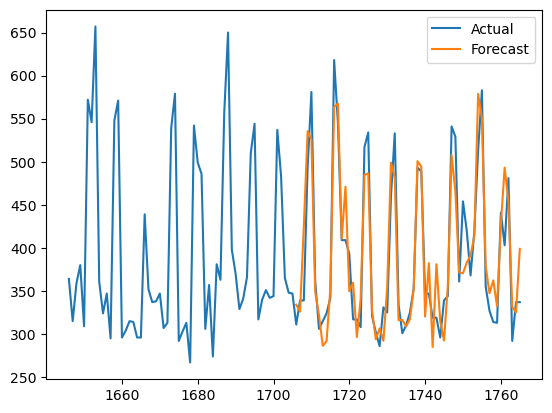

In [519]:
# Select the last 60 days of data for comparison
last_60_days = sarima_df.iloc[-60:]

# Extract the exogenous variables for the last 60 days
exog_data = last_60_days[sar_exo]

# Get the forecast for the next 60 days, including exogenous variables
forecast = sar.get_prediction(start=last_60_days.index[0]-780, end=last_60_days.index[-1]-780, exog=exog_data)

# Extract the predicted values for the next 60 days
predicted_values = forecast.predicted_mean

# Plot the actual sales and predicted values
plt.plot(sarima_df[-120:]['sales'], label = 'Actual')
plt.plot(predicted_values.index, predicted_values, label='Forecast')
plt.legend()
plt.show()

Sarima does a decent job to match the weekly trend and forecast it quite well. However, the problem with SARIMA is that we can only add one seasonality. However, the data has several seasonalities. There are ways around, but I think we will do way better with XGB or LightGB.

In [520]:
err = sarima_df[-60:]['sales'].to_numpy()-predicted_values.to_numpy()
sq_err = err**2
RMSE = np.sqrt(sq_err.mean())
print('The RMSE is: {}. Percentage Error is: {}'. format(RMSE,RMSE/sarima_df[-60:]['sales'].to_numpy().mean()))

The RMSE is: 37.93495376499992. Percentage Error is: 0.09751498434974355


# XGBoost or LGBoost

In [472]:
FEATURES = sar_exo

In [473]:
pred_split = 100
lag = 1
pred_split = pred_split+lag

# Create df that we make predictions for
pred_df = sarima_df[-pred_split:-lag]
pred_df['id'] = pred_df.index
# Create train and validation sets
df= sarima_df[FEATURES][:-pred_split]
y = np.log1p(sarima_df['sales'][:-pred_split])

In [474]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [475]:
xgb_params = {
    'predictor': 'cpu_predictor', 
    'verbosity': 1,
    'objective': 'reg:squarederror', 
    'eval_metric': 'rmse', 
    'random_state': 42,
    'learning_rate': 0.01,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 1.0,
    'reg_lambda': 0.1,
    'min_child_weight': 40,
}

In [476]:
df.shape

(1665, 40)

In [477]:

def train_model(df, y, test_size):
    
    temp_train_df = df.copy()
    X_train, X_test, y_train, y_test = train_test_split(temp_train_df, y, test_size=test_size,
                                                      random_state=42, shuffle=False)
    
    xgb_train = xgb.DMatrix(X_train, label=y_train)
    xgb_test = xgb.DMatrix(X_test, label=y_test)
    evallist = [(xgb_train, 'train'), (xgb_test, 'eval')]
    evals_result = dict()
    
    model = xgb.train(params=xgb_params, dtrain=xgb_train, evals=evallist, evals_result=evals_result,
                      verbose_eval=5000, num_boost_round=100000, early_stopping_rounds=100)
    return model

In [478]:
single_model = train_model(df, y, 0.2)

[0]	train-rmse:5.14691	eval-rmse:5.34005
[769]	train-rmse:0.26136	eval-rmse:0.31185


In [479]:
def make_predictions(model, X_test, features):
    pred_df = pd.DataFrame()
    id_df = pd.DataFrame()
    xgb_test = xgb.DMatrix(X_test[features])
    xgb_pred = pd.Series(model.predict(xgb_test, iteration_range=(0, model.best_iteration)),
                         name='xgb_pred')
    pred_df['sales_pred'] = (np.expm1(xgb_pred.map(lambda x: max(x, 0))) - 1).values
    pred_df['sales_pred'] = [a if a>0 else 0 for a in pred_df['sales_pred']]
    id_df['id'] = X_test['id'].copy()
    id_df.reset_index(drop=True, inplace=True)
    pred_df['id'] = id_df['id']
    return pred_df

In [480]:
preds = make_predictions(single_model, pred_df, FEATURES)
preds = pred_df.merge(preds[['id','sales_pred']],on=['id'], how='left')
preds.tail()

,date,sales,onpromotion,lag_16,lag_21,lag_30,lag_45,lag_60,lag_90,lag_120,lag_365,lag_730,SMA20_sales_lag16,SMA20_sales_lag30,SMA20_sales_lag60,sales_ewm_alpha_095_lag_16,sales_ewm_alpha_095_lag_30,sales_ewm_alpha_095_lag_60,sales_ewm_alpha_095_lag_90,sales_ewm_alpha_09_lag_16,sales_ewm_alpha_09_lag_30,sales_ewm_alpha_09_lag_60,sales_ewm_alpha_09_lag_90,sales_ewm_alpha_08_lag_16,sales_ewm_alpha_08_lag_30,sales_ewm_alpha_08_lag_60,sales_ewm_alpha_08_lag_90,sales_ewm_alpha_07_lag_16,sales_ewm_alpha_07_lag_30,sales_ewm_alpha_07_lag_60,sales_ewm_alpha_07_lag_90,sales_ewm_alpha_05_lag_16,sales_ewm_alpha_05_lag_30,sales_ewm_alpha_05_lag_60,sales_ewm_alpha_05_lag_90,workday,wageday,day_of_year,month,year,dcoilwtico_interpolated,is_december,id,sales_pred
95,2017-08-11,441.00,0.00,296.00,353.00,286.00,306.00,317.00,439.00,403.00,309.00,432.00,374.20,396.45,408.50,297.24,286.87,328.25,431.90,298.72,288.00,339.21,424.88,302.82,291.57,359.85,411.12,308.92,297.63,377.97,397.82,327.73,318.35,403.53,374.47,0,0,223,8,2017,48.81,0,1760,421.24
96,2017-08-12,403.00,1.00,339.00,493.00,331.00,315.00,340.00,352.00,493.00,303.00,344.00,375.75,396.05,409.85,336.91,328.79,339.41,355.99,334.97,326.70,339.92,359.29,331.76,323.11,343.97,363.82,329.98,320.99,351.39,365.75,333.36,324.67,371.76,363.23,0,0,224,8,2017,48.40,0,1761,466.25
97,2017-08-13,481.00,0.00,344.00,489.00,325.00,324.00,351.00,337.00,540.00,377.00,265.00,367.10,387.65,414.05,343.65,325.19,350.42,337.95,343.10,325.17,349.89,339.23,341.55,324.62,349.59,342.36,339.79,323.80,351.12,345.62,338.68,324.84,361.38,350.12,0,0,225,8,2017,48.00,0,1762,472.80
98,2017-08-14,292.00,0.00,541.00,347.00,460.00,342.00,342.00,338.00,499.00,382.00,245.00,367.45,381.60,404.05,531.13,453.26,342.42,338.00,521.21,446.52,342.79,338.12,501.11,432.92,343.52,338.87,480.64,419.14,344.74,340.29,439.84,392.42,351.69,344.06,1,0,226,8,2017,47.59,0,1763,318.47
99,2017-08-15,337.00,1.00,529.00,319.00,533.00,618.00,344.00,347.00,347.00,348.00,292.00,377.85,390.15,396.30,529.11,529.01,343.92,346.55,528.22,524.35,343.88,346.11,523.42,512.98,343.90,345.37,514.49,498.84,344.22,344.99,484.42,462.71,347.85,345.53,1,1,227,8,2017,47.57,0,1764,310.79


In [502]:
len(preds)

100

In [503]:
color_range = np.arange(0,1,len(preds))

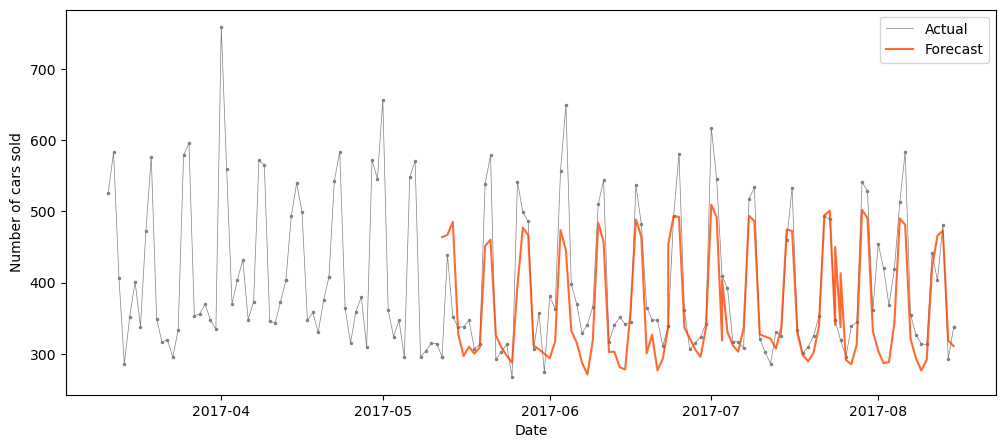

In [511]:
fig, axes = plt.subplots(1, 1, figsize = (12,5))
start=1600
plt.plot(sarima_df.date[start:],sarima_df.sales[start:], '.', color='grey',markersize=3)
plt.plot(sarima_df.date[start:],sarima_df.sales[start:],label = 'Actual', color='grey',linewidth=0.5)
#plt.plot(preds.date,preds['sales'], label = 'Actual')
plt.plot(preds.date,preds['sales_pred'], label = 'Forecast',color='orangered', alpha=0.8)
plt.xlabel('Date')
plt.ylabel('Number of cars sold')
plt.legend()
plt.show()

In [512]:
err = preds['sales'].to_numpy()-preds['sales_pred'].to_numpy()
sq_err = err**2
RMSE = np.sqrt(sq_err.mean())
print('The RMSE is: {}. Percentage Error is: {}'. format(RMSE,RMSE/preds['sales'].to_numpy().mean()))

The RMSE is: 60.61003258343055. Percentage Error is: 0.1551199827994562


XGBoost performed visually quite well. The forecast matches the weekends very well. It is underestimating to peaks slighly, but overall matches them well. It looks like it picked up the seasonality way better than SARIMA. SARIMA predicted some of the peaks very accurately, but others it is way off. XGBoost, on the other hand, seems more stable and always has a reasonable predictions. This also shown in the RMSE for both models.